<div class="alert alert-block">
Проектная работа
                        
Объект исследования- стартап, который продаёт продукты питания. 

    Цель проекта -нужно разобраться, как ведут себя пользователи вашего мобильного приложения. Узнать как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

    Спообы исследования - изучение воронк.  
    Исследование результатов A/A/B-эксперимента- дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно.  
    Договорились принять решение по результатам A/A/B-теста. 
    Создание двух групп A вместо одной

    Описание данных
Каждая запись в логе — это действие пользователя, или событие. 
 
    •	EventName — название события;
 
    •	DeviceIDHash — уникальный идентификатор пользователя;
 
    •	EventTimestamp — время события;
 
    •	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
</div>

In [85]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
from scipy import stats as st
from sklearn import datasets
import scipy.stats as stats
import math as mth

In [86]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = "\t")

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


EventName — название события;
DeviceIDHash **— уникальный идентификатор пользователя;
EventTimestamp — время события;
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальна

Подготовим данные к дальнейшей работе

Переименнуем столбцы в более удобные названия

In [88]:
df.rename(columns = {'EventName':'event', 'DeviceIDHash':'user_id', 'EventTimestamp':'times', 'ExpId':'test_group'}, inplace = True )
df.head(10)

,event,user_id,times,test_group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Изменим формат столбца 'times' и добавим отдельно столбец 'date'

In [89]:
df['times']=pd.to_datetime(df['times'], unit='s')
df['times'].dt.date
df['date'] = df['times'].dt.date
print(df.head())

                     event              user_id               times  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42   

   test_group        date  
0         246  2019-07-25  
1         246  2019-07-25  
2         248  2019-07-25  
3         248  2019-07-25  
4         248  2019-07-25  


In [90]:
#проверим данные на наличие дубликатов
print('Дубликатов:', df.duplicated().sum())
print('Процент дубликатов от всех данных:', "{0:.2%}".format(df.duplicated().sum() / len(df)))

Дубликатов: 413
Процент дубликатов от всех данных: 0.17%


Избавимся от дубликатов 

In [91]:
df = df.drop_duplicates().reset_index(drop=True)
df

,event,user_id,times,test_group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [92]:
#проверим данные на наличие дубликатов
print('Дубликатов:', df.duplicated().sum())
print('Процент дубликатов от всех данных:', "{0:.2%}".format(df.duplicated().sum() / len(df)))

Дубликатов: 0
Процент дубликатов от всех данных: 0.00%


Провеим пробелы в данных

In [93]:
df.isna().sum()

event         0
user_id       0
times         0
test_group    0
date          0
dtype: int64

Пропусков в данных нет, данные отобразились в полном объеме.

Данные готовы к дальнейшей работе, в них нет пропусков, процент дубликатов был не велик ( 0,17 %) от общего объема данных, все дубликаты удалены, пользователи разбиты на группы 246, 247, 248

Изучим и проверим данные
•	Сколько всего событий в логе?
•	Сколько всего пользователей в логе?
•	Сколько в среднем событий приходится на пользователя?
•	Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
•	Много ли событий и пользователей вы потеряли, отбросив старые данные?
•	Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.


In [94]:
event_df = len(df)
print('Всего событий в логе:', event_df)

Всего событий в логе: 243713


In [95]:
user_df = len(df)
print('Всего  в логе:', user_df)

Всего  в логе: 243713


In [96]:
n_users = df['user_id'].nunique()
print('Всего уникальных пользователей:', n_users)

Всего уникальных пользователей: 7551


In [97]:
#Сколько в среднем событий приходится на пользователя
print(f"В среднем на одного пользователя приходится {round(df.groupby('user_id').agg({'event': 'count'}).mean()[0], 1)} события")

В среднем на одного пользователя приходится 32.3 события


Необходимо поверить данные на выбросы, так как они влияют на результаты, проверим как именно записаны данные

In [98]:
df.groupby('user_id').agg({'event': 'count'}).describe()

,event
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


перцентиль распределения числа событий 75% на пользователя равен всего 37, а максимальное значение событий на одного пользователя  2307, можно сказать, что присутствуют выбросы и для расчета среднего лучше использовать медиану.

In [99]:
#Посмотрим сколько пользователей всего в логе
print('Всего пользователей в логе {}.'.format(df['user_id'].nunique()))
print('')

Всего пользователей в логе 7551.



Узнаем данными за какой период располагам? Найдите максимальную и минимальную дату.

In [100]:
print('Минимальная дата наблюдений:', df['date'].min())
print('Максимальная дата наблюдений:', df['date'].max())

Минимальная дата наблюдений: 2019-07-25
Максимальная дата наблюдений: 2019-08-07


Построим гистограмму по дате и времени

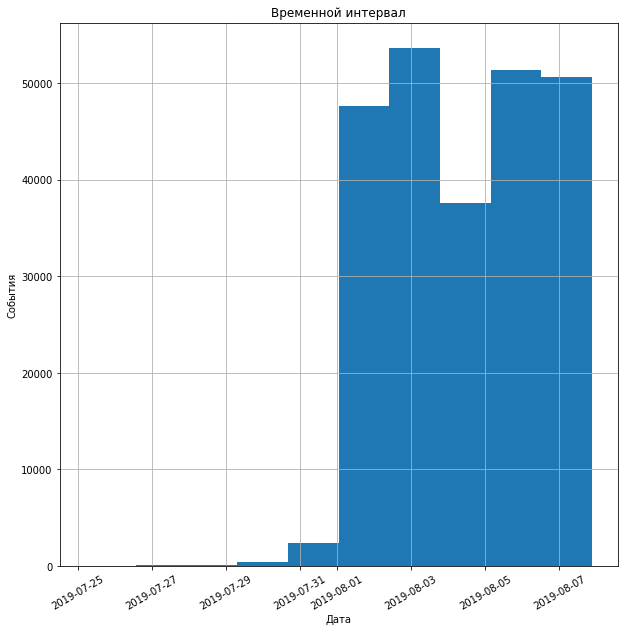

In [101]:
df['times'].hist(figsize=(10, 10))
plt.xticks(rotation=30)
plt.title('Временной интервал')
plt.xlabel('Дата')
plt.ylabel('События')
plt.show()

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные»
Как видно по гистограмме основная масса логов приходится на период с 1 по 7 августа 2019.
Судя по гистограмме истинный период данных 1-7.08.2019, записи до этой даты могли появиться ввиду разницы в часовых поясах или же пользователь мог начать сессию в один день и закончить на следующий, таким образом логично будет отбросить все записи до 1 августа.

In [102]:
# отбрасываем данные
df = df.query('times >= "2019-08-01"')
print('Новая минимальная дата наблюдений:', df['times'].min())

Новая минимальная дата наблюдений: 2019-08-01 00:07:28


Узнаем много ли событий потеряли отбросив старые данные?

In [103]:
print(f'Потеряли {event_df - len(df)} событий, что равно {round((event_df - len(df)) / event_df * 100, 2)}% от общего числа данных')

Потеряли 2826 событий, что равно 1.16% от общего числа данных


In [104]:
print(f"Потеряли {n_users - df['user_id'].nunique()} пользователей, что являлось {round((n_users - df['user_id'].nunique()) / n_users * 100, 2)}% от общего числа пользователей")

Потеряли 17 пользователей, что являлось 0.23% от общего числа пользователей


In [105]:
#Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.
df.groupby('test_group').agg({'user_id': 'nunique'})

,user_id
test_group,
246,2484
247,2513
248,2537


In [106]:
# проверим есть ли пользователи попавшие сразу в несколько групп
print('Количество пользователей, попавших в несколько групп:',\
      df.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1').count()[0])

Количество пользователей, попавших в несколько групп: 0


Данные отобразились в группах корректно,в каждой из групп есть пользователи,  пользователей попадающихся в разных группах нет. Потеряли после очистки данных всего 17 пользователей, что составило 0,23 процента от общего числа пользователей,что совсем немного и не явно не влияет на данные, можно работатьдальше с такими данными.

Изучим воронку событий

Отсортируем события по частоте

In [107]:
df.groupby('event')['event'].count().sort_values(ascending=False)

event
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

Всего 5 событий:
Main Screen Appear- Появление главного экрана          
OffersScreenAppear- Появление экрана предложений          
CartScreenAppear- Появление экрана корзины          
PaymentScreenSuccessful-Экран оплаты успешно      
Tutorial-Руководство    

Посчитаем, сколько пользователей совершали каждое из этих событий.
Отсортируем события по числу пользователей. 

In [108]:
events_by_users = df.groupby('event').agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False).reset_index()
events_by_users.columns = ['event', 'cnt_users']
events_by_users

,event,cnt_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали событие.

In [109]:
events_by_users['share'] = events_by_users['cnt_users'] / df['user_id'].nunique()
events_by_users.style.format({'share':'{:.2%}'})

,event,cnt_users,share
0,MainScreenAppear,7419,98.47%
1,OffersScreenAppear,4593,60.96%
2,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


Странно что на событии оплата 49.56 %, а на событии успешной оплаты 46.97%.Конверсия по этим данным довольно высокая 

Рассмотрим в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? 
Событие Tutorial- может происходить не зависимо от остальных событий.

In [110]:
funnel = events_by_users[['event', 'cnt_users']].query('event != "Tutorial"')
data = dict(values=funnel['cnt_users'].to_list(),
            labels=funnel['event'].to_list())
fig = px.funnel(data,  y='labels', x='values', title='Воронка продаж')
fig.show()

По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [111]:
funnel['conversion_per_step'] = 0

for index in range(0, len(funnel)):
    if index == 0:
        funnel.loc[index, 'conversion_per_step'] = 100
    else:
        funnel.loc[index, 'conversion_per_step'] = round(funnel.loc[index, 'cnt_users'] * 100 / funnel.loc[index - 1, 'cnt_users'], 2)
funnel

,event,cnt_users,conversion_per_step
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


Больше всего пользователей теряется при переходе от главного экрана к экрану с предложением, не доходит около 40%. Если в мобильном приложении есть опция сразу отправлять товар в корзину, не заходя на страницу с продуктом, это может объяснить высокую конверсию в 80% на следующем шаге.

In [112]:
funnel['conversion'] = 0

for index in range(0, len(funnel)):
    if index == 0:
        funnel.loc[index, 'conversion'] = 100
    else:
        funnel.loc[index, 'conversion'] = round(funnel.loc[index, 'cnt_users'] * 100 / funnel.loc[0, 'cnt_users'], 2)
funnel

,event,cnt_users,conversion_per_step,conversion
0,MainScreenAppear,7419,100.00,100.00
1,OffersScreenAppear,4593,61.91,61.91
2,CartScreenAppear,3734,81.30,50.33
3,PaymentScreenSuccessful,3539,94.78,47.70


Всего в воронке 5 событий:

Main Screen Appear- Появление главного экрана

OffersScreenAppear- Появление экрана предложений

CartScreenAppear- Появление экрана корзины

PaymentScreenSuccessful-Экран оплаты успешно

Tutorial-Руководство

Все пользователи ( 100%) совершают одно событие - посещают главную страницу, от главной страницы до успешной оплаты доходит 47.7 процентов пользователей, 61,91 % пользователей смотрят предложения на сайте, к ступеньке воронки CartScreenAppear доходит 50,33 процента, возможно люди не увидели для себя интересных предложений. Всего 47.70 % доходят до оплаты, что не плохо. Больше всего поьзователей терряется на шаге перехода от главной страницы к экрану предложения.
Если в мобильном приложении есть опция сразу отправлять товар в корзину, не заходя на страницу с продуктом, это может объяснить высокую конверсию в 80% на следующем шаге.

In [ ]:
от главной страницы до успешной оплаты доходит 47.7 процентов пользователей

Изучите результаты эксперимента
•	Сколько пользователей в каждой экспериментальной группе?
•	Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
•	Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
•	Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
•	Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.


In [113]:
#Еще раз проверим, что у нас есть пользователи из всех трёх экспериментальных групп.
df.groupby('test_group').agg({'user_id': 'nunique'})

,user_id
test_group,
246,2484
247,2513
248,2537


In [114]:
check_groups = df.query('event == "MainScreenAppear" & (test_group == 246 | test_group == 247)').groupby('test_group').agg({'user_id':'nunique'})
check_groups.columns = ['count_users']
total_246 = df.query('test_group == 246')['user_id'].nunique()
total_247 = df.query('test_group == 247')['user_id'].nunique()
check_groups.loc[246, 'share_users'] = check_groups.loc[246, 'count_users'] / total_246
check_groups.loc[247, 'share_users'] = check_groups.loc[247, 'count_users'] / total_247
check_groups.style.format({'share_users':'{:.2%}'})

,count_users,share_users
test_group,,
246,2450,98.63%
247,2476,98.53%


Сфомулируем гипотезы :
Н0- различий в долях между группами нет;
Н1- различия в долях между гуппами есть;

In [115]:
def test_z(group1, group2, event, alpha):

    def successes_trials(group1, group2, event):
    
        successes = np.array([df.query(f'test_group == {group1} & event == "{event}"')['user_id'].nunique(),\
                          df.query(f'test_group == {group2} & event == "{event}"')['user_id'].nunique()])

        trials = np.array([df.query(f'test_group == {group1}')['user_id'].nunique(),\
                           df.query(f'test_group == {group2}')['user_id'].nunique()])
        return successes, trials
    
    successes, trials = successes_trials(group1, group2, event) 
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
 
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
 
    # разница пропорций в датасетах
    difference = p1 - p2 
 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Результаты теста для групп {group1} и {group2} и события {event}')
 
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [116]:
test_z(246, 247, 'MainScreenAppear', 0.05)

Результаты теста для групп 246 и 247 и события MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [117]:
test_z(246, 247, 'OffersScreenAppear', 0.05)

Результаты теста для групп 246 и 247 и события OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [118]:
test_z(246, 247, 'CartScreenAppear', 0.05)

Результаты теста для групп 246 и 247 и события CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [119]:
test_z(246, 247, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп 246 и 247 и события PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проведя все тксты мы увидели что различия между группами небольшое, разбивка по группам верная

Сформулируем гипотезы:
Н0- различий в долях групп 246 и 248 нет
Н1- между долями есть значимая разница

In [120]:
test_z(246, 248, 'MainScreenAppear', 0.05)
print()
test_z(246, 248, 'OffersScreenAppear', 0.05)
print()
test_z(246, 248, 'CartScreenAppear', 0.05)
print()
test_z(246, 248, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп 246 и 248 и события MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248 и события OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248 и события CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248 и события PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем гипотезы:
Н0- различий в долях между объединенными контрольными группами 246, 247 и контрольной 248 нет
Н1- между долями есть значимая разница

In [122]:
# сравним объединенные контрольные 246 и 247 группы с экспериментальной 248
test_z([246, 247], 248, 'MainScreenAppear', 0.05)
print()
test_z([246, 247], 248, 'OffersScreenAppear', 0.05)
print()
test_z([246, 247], 248, 'CartScreenAppear', 0.05)
print()
test_z([246, 247], 248, 'PaymentScreenSuccessful', 0.05)

Результаты теста для групп [246, 247] и 248 и события MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп [246, 247] и 248 и события OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп [246, 247] и 248 и события CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп [246, 247] и 248 и события PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сформулируем гипотезы:
Н0-различий в долях между объединенными контрольными группами 246, 247 и контрольной 248 нет
Н1-между долями есть значимая разница

Как видим различий между контрольными группами 246 и 247 и экспериментальной 248 являются статистически незначимыми. Таким образом можно сказать, что изменение шрифтов во всем приложении не повлияло на воронку продаж, и пользователи переходят от шага к шагу в одинаковых пропорциях, независимо от шрифта приложения.

уровень значимости везде был равен 5%

Данные прошли А/А тест и А/А/В тесты,возможно кажется, что данных и экспериментов слишком много, но это необходимо так как по сути у нас несколько вилок развития событий, для точности и понимания, что данные корректны стоит проверить их со всех сторон.
При большом количестве экспериментов важно, чтобы вероятность ошибки первого рода была мала. Её можно контролировать с помощью статистических методов. Например, мы хотим, чтобы в каждом эксперименте вероятность ошибки первого рода не превышала 5% (это просто удобное значение, для собственных нужд можно брать другое). Тогда мы будем принимать эксперименты на уровне значимости 0.05.при одновременной проверке группы  статистических гипотез задача заключается в том, чтобы минимизировать число ложных отклонений V и ложных принятий, не зависимо от метода эксперимента,так как унас нет различий в выводах относительно принятия Н0 гипотезы, нам нет необходимости корректировать эксперим

ВЫВОД:

Ознакомившись с результатами тестов (А/А, А/В), отсеяв не корректные данные и взяв за базовые данные даты с 01.08.2019 по 07.08.2019 г., мы увидели, что на каждого пользователя примерно приходится около 20 событий. Все пользователи посещают главный экран, а вот инструкции интересуют очень маленькийи процент пользователей, до оплаты доходят 47 % пользователей.
  
По проведенным  тестам, различий в двух контрольных группах не выявлено, это означает, что данные собраны качественно и результатам A/A/B-теста можно доверять.
    
По проведенным статистическим тестам различий между контрольными группа и экспериментальной также не выявлено, как при сравнении по отдельности так и при объединении контрольных групп в одну.



Из этого следует, что на основании корректно проведенного A/A/B-теста изменение шрифтов в приложении не повлияло на поведение пользователей. 

Эксперимент продолжaть не стоит, и менять шрифты нет ни какой необходимости